# Bias Analysis of the models trained as part of the automoderation model

A bias analysis was conducted on the three models trained by the team for the automoderation tool: Safeguarding, Complaints, and Not an Experience. The analysis aimed to evaluate the fairness of these models by examining the sentiment of misclassified comments, the length of the texts, and the number of spelling mistakes standardized by text length, to identify any potential bias in the models.

The models operate in contexts where demographic data is not accessible, relying solely on textual content to make classifications. As such, it is crucial to ensure that these models do not inadvertently favour or penalize certain characteristics that could lead to biased outcomes. For instance, longer texts might be inherently more complex or contain more nuanced sentiment, affecting their classification. Similarly, the frequency of spelling mistakes is a proxy for the literacy levels of the writer and we definitely don't want to favour, for example, positive reviews over negative ones.

**Methods**
- Create a confusion matrix to easily see how well the model predictions match the true labels.
- Plot the boxplot of each feature (length, spelling and sentiment) to visually compare across the confusion matrix categories (TP, TN, FP, FN) and between correctly and incorrectly classified instances (trues vs falses).
- Perform a Shapiro-Wilk test to check if the data in these two groups are normally distributed (correctly and incorrectly). This is to decide if we use a t-test (this is for normally distributed samples) or a Mann-Whitney U test (for non-parametrics); both are suitable for ordinal or continuous data. 
- Conduct a Mann-Whitney U test. If the data is normally distributed, it also performs a t-test, this is to check for significant differences between the two groups (correctly and incorrectly).
- Calculate the effect size using Cohen's d which measures the size of the difference.
> Cohen's d is a measure of effect size used to indicate the standardized difference between two means. It's a useful statistic to interpret the > practical significance of a finding, particularly in contrast to the p-value which only indicates whether the result is statistically significant. > Here's how to interpret Cohen's d (see more here):
> Magnitude of Cohen's d:

> Small effect: d ≈ 0.2
> Medium effect: d ≈ 0.5
> Large effect: d ≈ 0.8 or greater

In [ ]:
import urllib.request
import json
import ssl
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mannwhitneyu, shapiro, ttest_ind

from textblob import TextBlob
from spellchecker import SpellChecker

JS: request doesn't seem to be used

In [1]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = # REDACTED
resource_group = # REDACTED
workspace_name = # REDACTED

workspace = Workspace(subscription_id, resource_group, workspace_name)

# Loading data

In [73]:
#NAE
nae = Dataset.get_by_name(workspace, name='not_an_experience_1000_Oct23_Finola')
nae_df = nae.to_pandas_dataframe()
new_nae = Dataset.get_by_name(workspace, name='nae_220_24Nov23_DanFinola')
new_nae_df = new_nae.to_pandas_dataframe()

#uninf
unif= Dataset.get_by_name(workspace, name='Uninformative_sept_23_gouldthorpe_oct_23_reviewed')
unif_df = unif.to_pandas_dataframe()

#published
pub = Dataset.get_by_name(workspace, name='published_1897_17Oct23_dynamics')
pub_df = pub.to_pandas_dataframe()
new_pub = Dataset.get_by_name(workspace, name='published_1000_24Nov23_DanFinola')
new_pub_df = new_pub.to_pandas_dataframe()

# prepare data, merge multiple files into a single one
all_nae_df = pd.concat([nae_df,new_nae_df], axis=0, ignore_index=True)
all_pub_df = pd.concat([pub_df,new_pub_df], axis=0, ignore_index=True)

#safeguarding
safeguarding_dataset = Dataset.get_by_name(workspace, name='safeguarding_for_validation_v0')
safeguarding_val_df = safeguarding_dataset.to_pandas_dataframe()

safe_latest_year = Dataset.get_by_name(workspace, name='safeguarding_201_Dec22_Dec23_lee')
safe_latest_year_df = safe_latest_year.to_pandas_dataframe()


In [79]:
# Safeguarding
# First, let's create the new DataFrame with the renamed columns and new values
not_safeguarding_df = all_pub_df.rename(columns={'Comment Text': 'text'}).copy()
not_safeguarding_df = not_safeguarding_df.sample(n=200, random_state=81) # To make a fully balanced validation set
not_safeguarding_df['label'] = 0  # Setting the label for all these new records to 0
not_safeguarding_df['origin'] = 'Pub'  # Setting the origin for these records

# Now we select only the relevant columns to match the safeguarding_val_df structure
not_safeguarding_df = not_safeguarding_df[['text', 'label', 'origin']]

# Concatenate
safeguarding_val_df2 = pd.concat([safeguarding_val_df, not_safeguarding_df], ignore_index=True)

In [4]:
# NAE
nae_comb_df = pd.concat([all_nae_df, all_pub_df], axis=0, ignore_index=True)
nae_comb_df = nae_comb_df[["Comment ID", "Comment Text", "not_an_experience", "val"]]

nae_val_df = nae_comb_df[nae_comb_df["val"] == 1]

In [5]:
# Complaints
complaints_dataset = Dataset.get_by_name(workspace, name='complaints_dg_DanFinola_dec_reboot')
complaints_df = complaints_dataset.to_pandas_dataframe()


complaints_dataset2 = Dataset.get_by_name(workspace, name='complaints_from_18Oct23_to_15Nov_unreviewed')
complaints_df2 = complaints_dataset2.to_pandas_dataframe()

combined = pd.concat([complaints_df2, complaints_df])
all_complaints_no_duplicates = combined.drop_duplicates(subset=['Comment Text'])

all_pub_df["Is Complaint"] = 0  # Setting the label for all these new records to 0


complaints_comb_df =  pd.concat([all_complaints_no_duplicates, all_pub_df], axis=0, ignore_index=True)
complaints_comb_df = complaints_comb_df[["Comment ID", "Comment Text", "Is Complaint", "val"]]

# Filtering for rows where 'val' column has a 1 and printing the number of such records
complaints_val_df = complaints_comb_df[complaints_comb_df['val'] == 1]

# #Run this cell to look for duplicate records. Update: No duplicates were found, we are good to go, leave for reference on how this was checked
# import pandas as pd

# len_complaints_df2 = len(complaints_df2)
# len_complaints = len(complaints_df)
# print(f"Number of records in complaints_df2: {len_complaints_df2}")
# print(f"Number of records in complaints: {len_complaints}")

# # Checking for duplicates based on the 'Comment_Text' column and creating a new dataframe without these duplicates
# combined = pd.concat([complaints_df2, complaints_df])
# combined_no_duplicates = combined.drop_duplicates(subset=['Comment Text'])

# # Printing the number of records in the new dataframe
# len_combined_no_duplicates = len(combined_no_duplicates)
# print(f"Number of records in combined dataset without duplicates (based on 'Comment Text'): {len_combined_no_duplicates}")

# # Filtering for rows where 'val' column has a 1 and printing the number of such records
# filtered = combined_no_duplicates[combined_no_duplicates['val'] == 1]
# len_filtered = len(filtered)
# print(f"Number of records with 'val' = 1: {len_filtered}")


In [7]:

# Creating a dummy DataFrame for quick tests
data = {
    "Comment Text": ["This is a test comment.", 
                     "Another example of a comment.", 
                     "Yet another comment text, telling the world that I will kill myself.", 
                     "The pressure is too much, I doubt I'll get the help Id need from the NHS so I'm considering ending my life.", 
                     "Final comment in the dataset."]
}

test_df = pd.DataFrame(data)

# Set up connection with endpoint

These functions send a request to a machine learning model endpoint, hosted on Azure ML,
passing a text query for processing. The request includes headers such as API key for
authorization and content type. It handles both successful responses and HTTP errors.

In [8]:
def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True)

def query_endpoint(text, endpoint_url, api_key, aml_mod_deployment):
    """
    Send a text query to a specified endpoint and return the response.

    Args:
        text (str): The text query to be sent to the model.
        endpoint_url (str): The URL of the endpoint where the machine learning model is hosted.
        api_key (str): The API key required for authorization with the endpoint.
        aml_mod_deployment (str): The Azure ML model deployment name, a single endpoint can have multiple deployments and this needs to be specified.

    Returns:
        dict: The response from the endpoint, parsed from JSON format, or None if an error occurs.

    """

    allowSelfSignedHttps(True)  # Needed if using a self-signed certificate

    # Prepare the data for the request
    data = {"data": [text]}
    body = str.encode(json.dumps(data))

    # Set headers, including the API key for authorization
    headers = {
        'Content-Type': 'application/json',
        'Authorization': 'Bearer ' + api_key,
        'azureml-model-deployment': aml_mod_deployment
    }

    # Create and send the request
    req = urllib.request.Request(endpoint_url, body, headers)
    try:
        response = urllib.request.urlopen(req)
        result = response.read()
        return json.loads(result)  # Assuming the response is JSON formatted
    except urllib.error.HTTPError as error:
        print("Request failed with status code:", error.code)
        print(error.info())
        print(error.read().decode("utf8", 'ignore'))
        return None  # or handle the error as needed


In [9]:
# The equivalent of query_endpoint function but for the safeguarding model only

def safeguarding_rule(submission_words, endpoint_url, api_key):
    """Send a text query to a the safeguarding endpoint and return the response. Check comment and title for safeguarding indications such as selfharm

    Args:
        submission_words : list of strings to check for safeguarding concerns
    Returns:
        tuple of length 3: first value is the score,
        second value is wether there is safeguarding risk,
        and what level of risk, third value is probability
    """
       
    url = endpoint_url
    api_key = api_key
    body=str.encode(json.dumps({"data":submission_words}))
    
    headers = {
        'Content-Type': 'application/json', 
        'Authorization': ('Bearer '+ api_key),
        'azureml-model-deployment': 'safeguarding',
        }

    req = urllib.request.Request(url, body, headers)
    response = urllib.request.urlopen(req)
    result = response.read()
    result = json.loads(result)
    predicted_classes = json.loads(result)
   
    score = 0

    if predicted_classes["0"] == "Possibly Concerning":
        score = 1
    elif predicted_classes["0"] == "Strongly Concerning":
        score = 2
    return score, [predicted_classes["0"]], predicted_classes["1"]

# Predictions to validate and do bias analysis

## bias analysis functions

In [12]:
#to run on new environments
#pip install pyspellchecker
# pip install textblob

In [13]:
def add_text_features_to_dataframe(dataframe, text_column):
    """
    Analyse the text in a specific column of a dataframe.
    Adds columns for text length, sentiment, and rate of spelling mistakes.
    
    Args:
    dataframe (pd.DataFrame): The dataframe containing the text data.
    text_column (str): The name of the column with text to analyse.

    Returns:
    pd.DataFrame: A new dataframe with the additional columns.
    """

    # Initialize the spell checker
    spell = SpellChecker()

    # Function to count spelling mistakes in a text
    def count_spelling_mistakes(text):
        words = text.split()
        misspelled = spell.unknown(words)
        return len(misspelled)

    # Apply functions to the dataframe
    dataframe['text_length'] = dataframe[text_column].apply(lambda x: len(x.split()))
    dataframe['sentiment'] = dataframe[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['spelling_mistakes'] = dataframe[text_column].apply(count_spelling_mistakes)

    # Calculate rate of spelling mistakes (mistakes per word)
    dataframe['spelling_mistakes_rate'] = dataframe['spelling_mistakes'] / dataframe['text_length']

    # Replace potential NaN values in 'spelling_mistakes_rate' with 0 (for texts with no words)
    dataframe['spelling_mistakes_rate'].fillna(0, inplace=True)

    return dataframe

In [1]:

def cohen_d(x, y):
    """
    This function calculates Cohen's d, a measure of effect size, for two independent samples.
    Args:
        x (array-like): A sequence of numbers representing the first sample.
        y (array-like): A sequence of numbers representing the second sample.

    Returns:
        float: The calculated Cohen's d value.
    The function calculates the pooled standard deviation of the two samples and then computes the difference
    between their means, normalized by this pooled standard deviation. This gives the effect size in terms of
    the number of standard deviations that separate the two sample means. A larger absolute value of Cohen's d
    indicates a larger effect size.
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

def perform_statistical_tests(group1, group2):
    """
    Performs various statistical tests to evaluate the difference between two groups.
    
    This function first checks if each group has enough data to perform the Shapiro-Wilk test for normality. 
    If both groups are normally distributed, a T-test is performed to compare the means. 
    Regardless of normality, the Mann-Whitney U test is performed to compare the distributions.
    Cohen's d is calculated to determine the effect size between the two groups.
    
    Parameters:
    - group1 (array-like): Numerical data for the first group.
    - group2 (array-like): Numerical data for the second group.
    
    Returns:
    - str: A conclusion string summarizing the outcomes of the normality tests, 
      Mann-Whitney U test, T-test (if applicable), and the effect size.
    """    
    # Check if groups have enough data for the Shapiro-Wilk test
    if len(group1) < 3:
        print(f"Not enough data for Shapiro test in group1 (less than 3 records).")
        normal_group1 = False
    else:
        normal_group1 = shapiro(group1).pvalue > 0.05
        print(f"Normality Test for group1: {'Normal' if normal_group1 else 'Not Normal'}")
    
    if len(group2) < 3:
        print(f"Not enough data for Shapiro test in group2 (less than 3 records).")
        normal_group2 = False
    else:
        normal_group2 = shapiro(group2).pvalue > 0.05
        print(f"Normality Test for group2: {'Normal' if normal_group2 else 'Not Normal'}")

    print(f"Normality Test for group1: {'Normal' if normal_group1 else 'Not Normal'}")
    print(f"Normality Test for group2: {'Normal' if normal_group2 else 'Not Normal'}")

    effect_size = cohen_d(group1, group2)

    u_stat, mw_p_val = mannwhitneyu(group1, group2)

    t_stat, t_p_val = (None, None)
    if normal_group1 and normal_group2:
        t_stat, t_p_val = ttest_ind(group1, group2)

    alpha = 0.05
    conclusion = f'Effect size (Cohen\'s d): {effect_size:.3f}\n'
    conclusion += f'Mann-Whitney U test: p = {mw_p_val:.5f}. '
    conclusion += 'Statistically significant difference.\n' if mw_p_val < alpha else 'No statistically significant difference.\n'
    if t_stat is not None:
        conclusion += f'T-test: p = {t_p_val:.5f}. '
        conclusion += 'Statistically significant difference.\n' if t_p_val < alpha else 'No statistically significant difference.\n'
    
    return conclusion

def bias_analysis_full(dataframe, feature, label_column, predicted_column):
    """
    Analyses bias in predictions by comparing feature distributions across different classification outcomes.
    
    This function displays the confusion matrix for the provided label and prediction columns.
    It categorizes each prediction into True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN),
    and adds this categorization along with a flag indicating correct or incorrect classification to the dataframe.
    Boxplots are generated to visualize the distribution of the specified feature across the classification groups and
    based on the correctness of the classification.
    It then performs statistical tests (using the perform_statistical_tests function) to compare the feature's distribution
    between correct vs. incorrect classifications, TP vs. FN, and TN vs. FP.
    
    Parameters:
    - dataframe (pandas.DataFrame): The dataset containing the features, labels, and predictions.
    - feature (str): The name of the feature to analyse for bias.
    - label_column (str): The name of the column containing the true labels.
    - predicted_column (str): The name of the column containing the predicted labels.
    
    Outputs:
    - Displays confusion matrix and boxplots for visual analysis.
    - Prints conclusions from statistical tests comparing feature distributions across classification outcomes.
    """
    # Display the confusion matrix
    cm = confusion_matrix(dataframe[label_column], dataframe[predicted_column])
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(cm).plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    # Categorize classification 
    conditions = [
        (dataframe[label_column] == 1) & (dataframe[predicted_column] == 1),  # TP
        (dataframe[label_column] == 0) & (dataframe[predicted_column] == 0),  # TN
        (dataframe[label_column] == 0) & (dataframe[predicted_column] == 1),  # FP
        (dataframe[label_column] == 1) & (dataframe[predicted_column] == 0)   # FN
    ]
    choices = ['TP', 'TN', 'FP', 'FN']
    dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
    dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Classification_Group', y=feature, data=dataframe, showfliers=False)
    plt.title('Boxplot by Classification Group (TP, TN, FP, FN)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Correct_Classification', y=feature, data=dataframe, showfliers=False)
    plt.title('Boxplot by Correct Classification')
    plt.show()

    # Create groups for comparison
    tp = dataframe[(dataframe[label_column] == 1) & (dataframe[predicted_column] == 1)][feature]
    tn = dataframe[(dataframe[label_column] == 0) & (dataframe[predicted_column] == 0)][feature]
    fp = dataframe[(dataframe[label_column] == 0) & (dataframe[predicted_column] == 1)][feature]
    fn = dataframe[(dataframe[label_column] == 1) & (dataframe[predicted_column] == 0)][feature]
    correct = dataframe[dataframe['Correct_Classification']][feature]
    incorrect = dataframe[~dataframe['Correct_Classification']][feature]

    # Perform statistical tests for each pair
    correct_incorrect_conclusion = perform_statistical_tests(correct, incorrect)
    tp_fn_conclusion = perform_statistical_tests(tp, fn)
    tn_fp_conclusion = perform_statistical_tests(tn, fp)

    
    # Print conclusions
    print("Correct vs Incorrect Classification:")
    print(correct_incorrect_conclusion)
    print("True Positives vs False Negatives:")
    print(tp_fn_conclusion)
    print("\nTrue Negatives vs False Positives:")
    print(tn_fp_conclusion)

    return correct_incorrect_conclusion, tp_fn_conclusion, tn_fp_conclusion


## Safeguarding

In [15]:
#New
safe_endpoint_url = # REDACT
safe_api_key = # REDACT


test_safeguarding = safeguarding_rule('The sun is shining and is lovely', safe_endpoint_url, safe_api_key)
test_safeguarding

(0, ['No safeguarding'], '0.9993838')

The accuracy is 0.91
The F1 score is 0.91
The precision is 0.92
The recall is 0.91


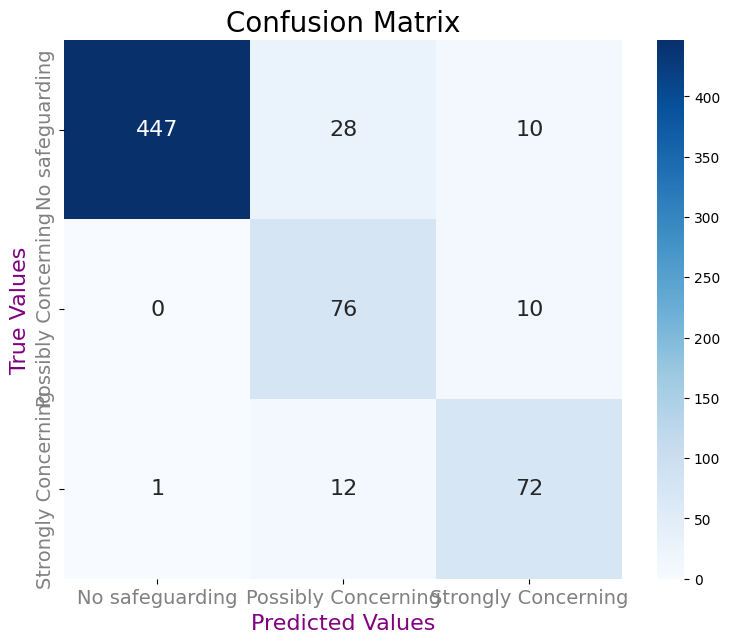

In [81]:
#Sample
safeguarding_val_df = safeguarding_val_df2

# Define a mapping from text labels to numeric labels to compute metrics
label_mapping = {'No safeguarding': 0, 'Possibly Concerning': 1, 'Strongly Concerning': 2}


# Applying the function to the dataframe
safeguarding_val_df['predicted_tuple'] = safeguarding_val_df['text'].apply(
    lambda x: safeguarding_rule(x, safe_endpoint_url, safe_api_key)
)


# Unpacking the predictions from the tuples
safeguarding_val_df['predicted_score'] = safeguarding_val_df['predicted_tuple'].apply(lambda x: x[0])
safeguarding_val_df['predicted_label'] = safeguarding_val_df['predicted_tuple'].apply(lambda x: x[1][0])
safeguarding_val_df['predicted_probability'] = safeguarding_val_df['predicted_tuple'].apply(lambda x: x[2])

# Convert predicted text labels to numeric labels for metric computation
safeguarding_val_df['predicted_numeric'] = safeguarding_val_df['predicted_label'].map(label_mapping)

# Extracting the true and predicted labels for metric calculation
y_true = safeguarding_val_df['label']
y_pred = safeguarding_val_df['predicted_numeric']


# Calculate metrics with zero_division parameter set to control the behavior for undefined metrics, and average weighted for multiclass
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the evaluation metrics 
print(f"The accuracy is {accuracy:.2f}")
print(f"The F1 score is {f1:.2f}")
print(f"The precision is {precision:.2f}")
print(f"The recall is {recall:.2f}")

# Plotting the confusion matrix 
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 16})
ax.set_title('Confusion Matrix', size=20)
ax.set_xlabel('Predicted Values', size=16, color='purple')
ax.set_ylabel('True Values', size=16, color='purple')
ax.xaxis.set_ticklabels(['No safeguarding', 'Possibly Concerning', 'Strongly Concerning'], size=14, color='gray')
ax.yaxis.set_ticklabels(['No safeguarding', 'Possibly Concerning', 'Strongly Concerning'], size=14, color='gray')
plt.show()

In [82]:
# Convert the true labels and predicted labels to binary classes: 0 remains 0, 1 and 2 become 1
safeguarding_val_df['binary_label'] = safeguarding_val_df['label'].apply(lambda x: 1 if x in [1, 2] else 0)
safeguarding_val_df['binary_predicted'] = safeguarding_val_df['predicted_numeric'].apply(lambda x: 1 if x in [1, 2] else 0)

### Bias analysis

In [83]:
analyzed_df = add_text_features_to_dataframe(safeguarding_val_df, 'text')

# Add a column to indicate correct or incorrect classification
analyzed_df['Classification_Correct'] = analyzed_df['binary_label'] == analyzed_df['binary_predicted']

<Figure size 800x600 with 0 Axes>

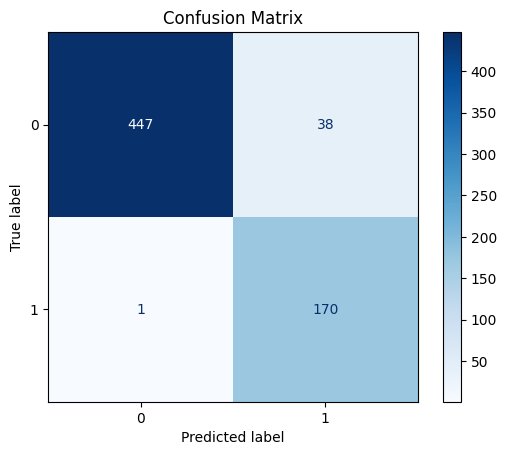

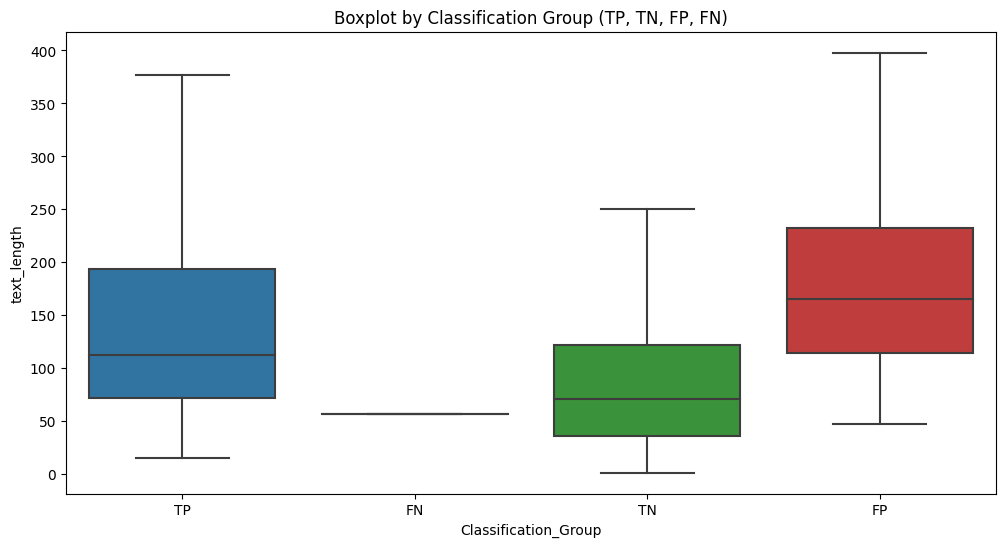

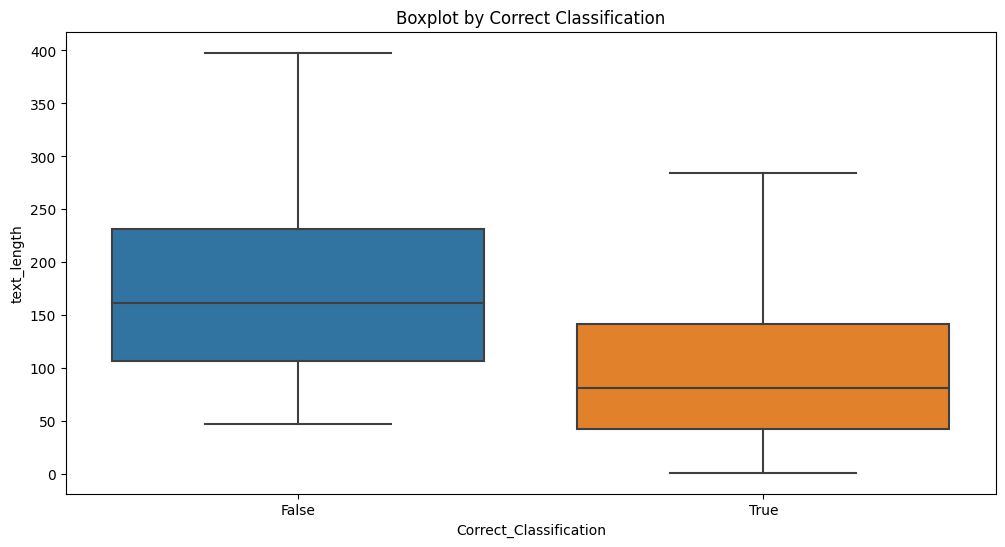

Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Not enough data for Shapiro test in group2 (less than 3 records).
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): -0.637
Mann-Whitney U test: p = 0.00000. Statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): nan
Mann-Whitney U test: p = 0.13698. No statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): -1.070
Mann-Whitney U test: p = 0.00000. Statistically significant difference.



In [91]:
# Perform the bias analyxis
bias_analysis_full(analyzed_df, 'text_length', 'binary_label', 'binary_predicted')

<Figure size 800x600 with 0 Axes>

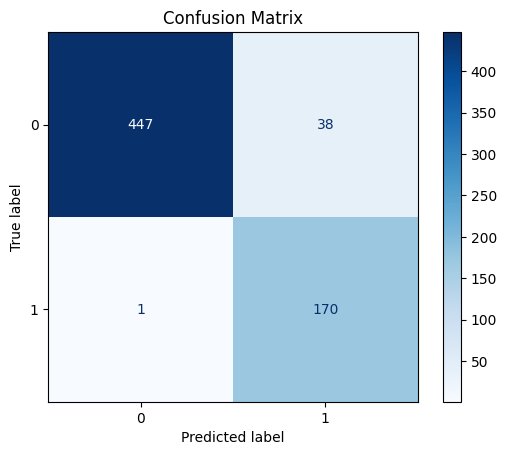

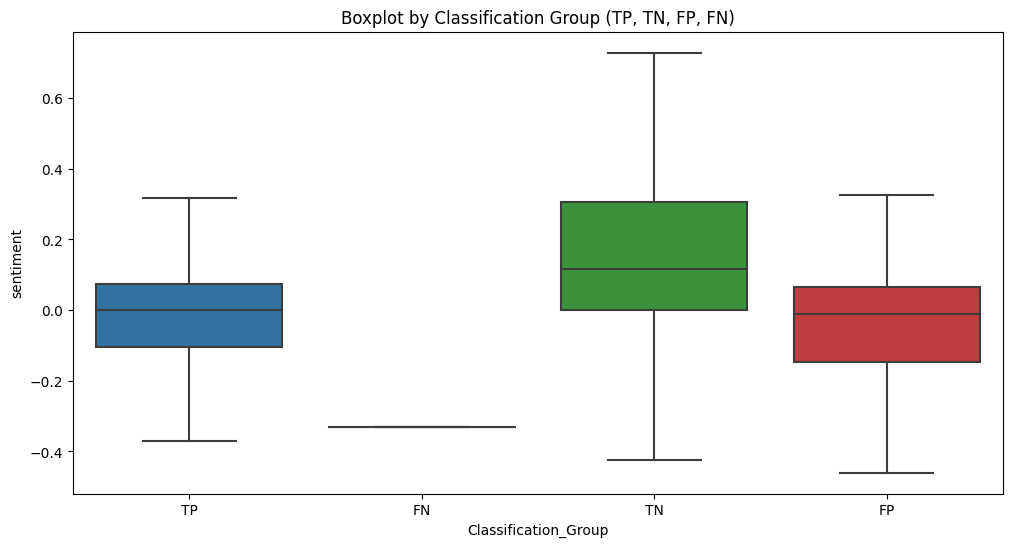

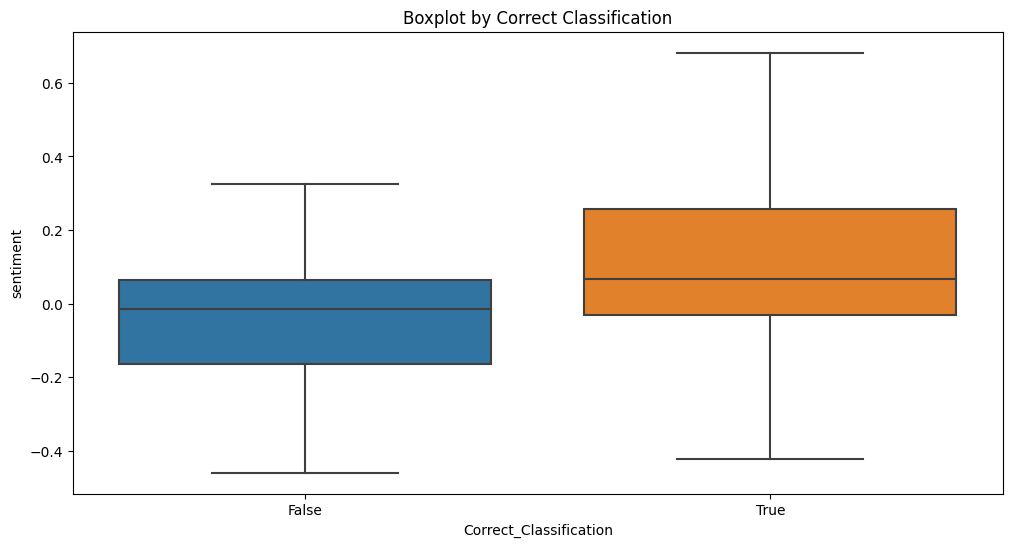

Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Not enough data for Shapiro test in group2 (less than 3 records).
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): 0.648
Mann-Whitney U test: p = 0.00022. Statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): nan
Mann-Whitney U test: p = 0.06060. No statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): 0.801
Mann-Whitney U test: p = 0.00001. Statistically significant difference.

None


In [92]:
# Perform the SENTIMENT
conclusion = bias_analysis_full(analyzed_df, 'sentiment', 'binary_label', 'binary_predicted')
print(conclusion)

<Figure size 800x600 with 0 Axes>

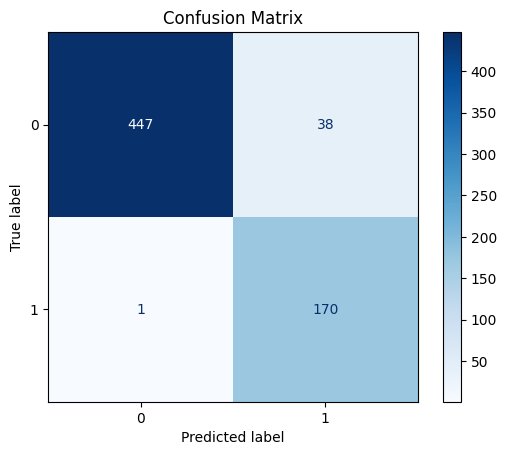

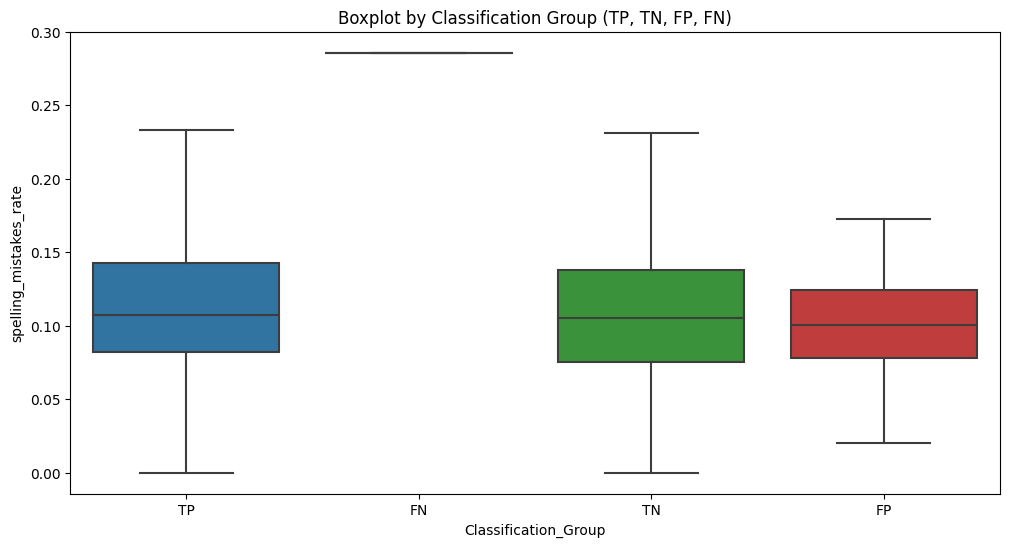

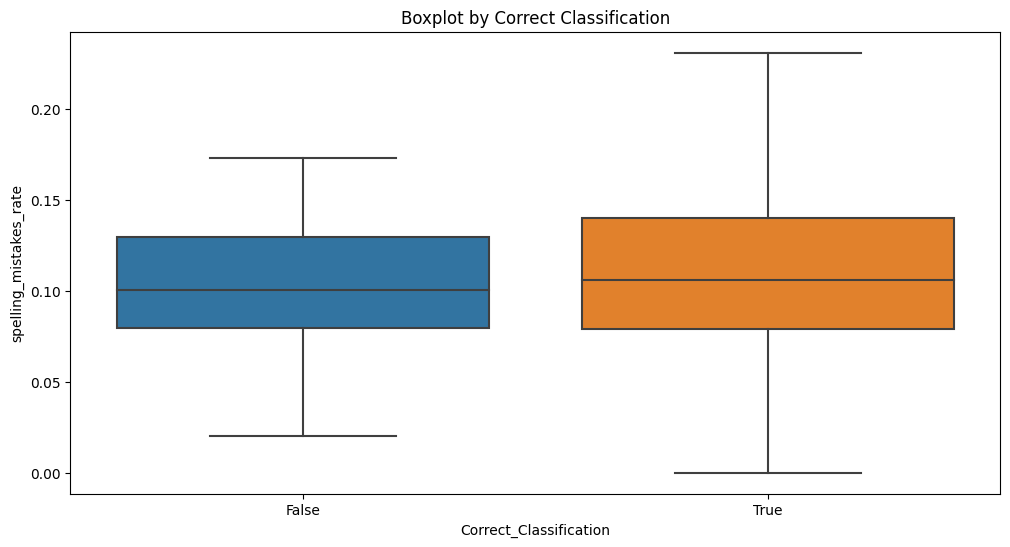

Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Not enough data for Shapiro test in group2 (less than 3 records).
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): 0.161
Mann-Whitney U test: p = 0.16136. No statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): nan
Mann-Whitney U test: p = 0.04346. Statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): 0.213
Mann-Whitney U test: p = 0.14257. No statistically significant difference.

None


In [93]:
# Perform the SPELLING MISTAKES
conclusion = bias_analysis_full(analyzed_df, 'spelling_mistakes_rate', 'binary_label', 'binary_predicted')
print(conclusion)

## Not an experience

### test connection

In [25]:
nae_url = # REDACT
nae_key = # REDACT
nae_3head = # REDACT

In [35]:
test_nae = query_endpoint('It is always great to visit this practice', nae_url, nae_key, nae_3head)
test_nae

'{"0": "1", "1": "0.8433863097144977"}'

### validation nae

In [54]:
#Process the dataset using the response from the endpoint

def process_dataset(dataset, text_column, endpoint_url, api_key, aml_mod_deployment):
    predictions = []
    probabilities = []

    for text in dataset[text_column]:
        # Call the query_endpoint function
        response = query_endpoint(text, endpoint_url, api_key, aml_mod_deployment)
        
        if response is not None:
            # Parse the response string to a dictionary
            response_dict = json.loads(response)

            # Extract prediction and probability
            prediction = response_dict.get('0')
            probability = response_dict.get('1')

            # Convert prediction to integer, if it's not None
            if prediction is not None:
                prediction = int(prediction)
        else:
            # Handle cases where the query_endpoint does not return a response
            prediction = None
            probability = None

        predictions.append(prediction)
        probabilities.append(probability)

    # Add the predictions and probabilities to the dataset
    dataset['prediction'] = predictions
    dataset['probability'] = probabilities

    return dataset

In [55]:
def evaluate_predictions_given_a_dataset(dataset, prediction_column, label_column):
    # Extract predictions and true labels
    predictions = dataset[prediction_column].astype(int)  # Convert predictions to int
    true_labels = dataset[label_column]

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='binary')
    precision = precision_score(true_labels, predictions, average='binary')
    recall = recall_score(true_labels, predictions, average='binary')

    # Print the evaluation metrics
    print(f"The accuracy is {accuracy:.2f}")
    print(f"The F1 score is {f1:.2f}")
    print(f"The precision is {precision:.2f}")
    print(f"The recall is {recall:.2f}")

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 16})
    ax.set_title('Confusion Matrix', size=20)
    ax.set_xlabel('Predicted Values', size=16)
    ax.set_ylabel('True Values', size=16)
 
    plt.show()



In [56]:
nae_df_withprediction =  process_dataset(nae_val_df, 'Comment Text', nae_url, nae_key, nae_3head)

/tmp/ipykernel_8000/3013107152.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['prediction'] = predictions
/tmp/ipykernel_8000/3013107152.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['probability'] = probabilities


The accuracy is 0.89
The F1 score is 0.81
The precision is 0.80
The recall is 0.81


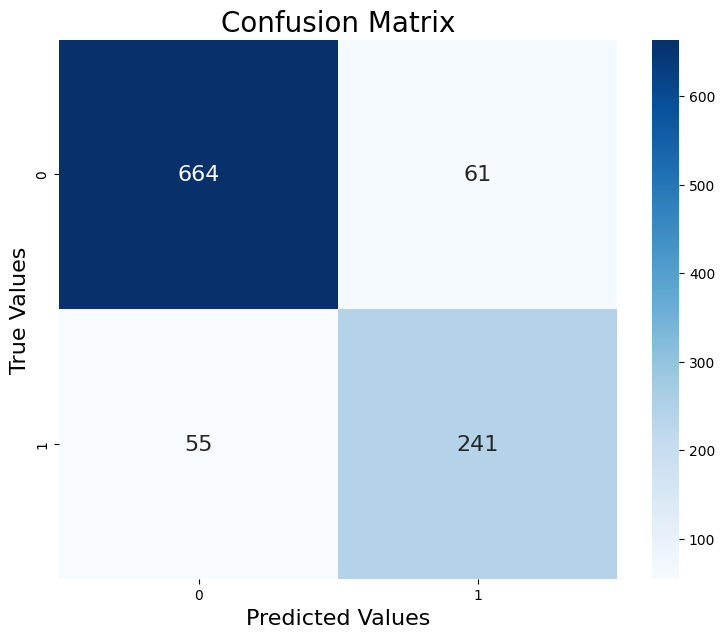

In [57]:
evaluate_predictions_given_a_dataset(nae_df_withprediction, 'prediction', 'not_an_experience')

### bias analysis

In [58]:
analyzed_nae_df = add_text_features_to_dataframe(nae_df_withprediction, 'Comment Text')

/tmp/ipykernel_8000/1309993489.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['text_length'] = dataframe[text_column].apply(lambda x: len(x.split()))
/tmp/ipykernel_8000/1309993489.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['sentiment'] = dataframe[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
/tmp/ipykernel_8000/1309993489.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<Figure size 800x600 with 0 Axes>

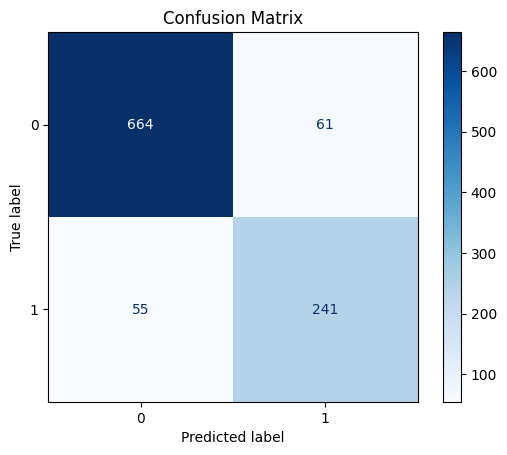

/tmp/ipykernel_8000/4182892165.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
/tmp/ipykernel_8000/4182892165.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])


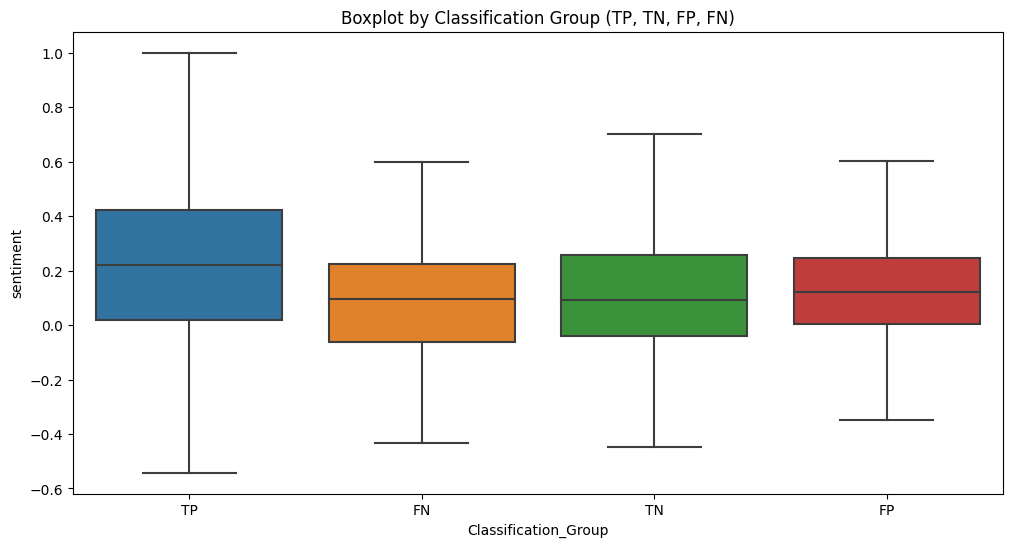

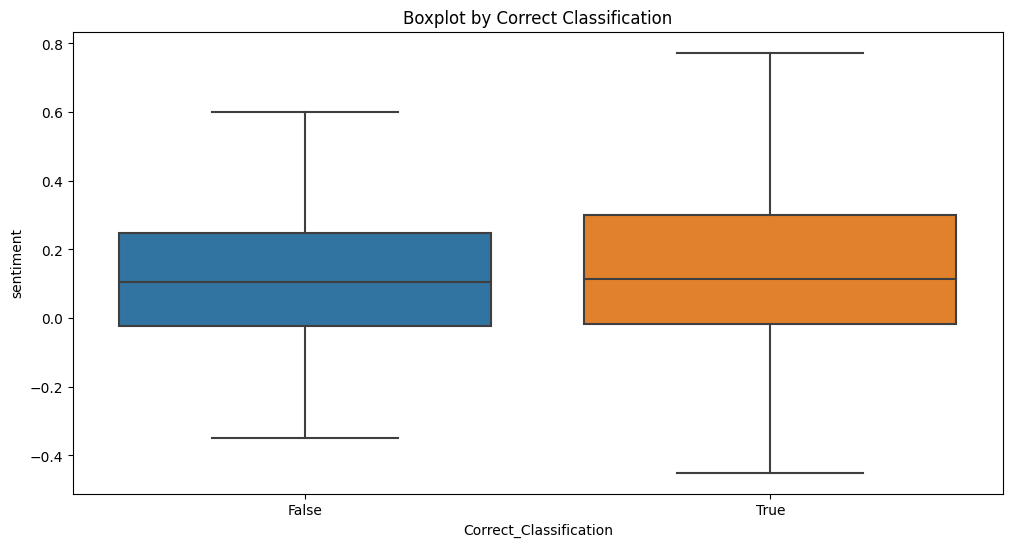

Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): 0.103
Mann-Whitney U test: p = 0.25339. No statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): 0.486
Mann-Whitney U test: p = 0.00101. Statistically significant difference.
T-test: p = 0.00128. Statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): -0.123
Mann-Whitney U test: p = 0.14895. No statistically significant difference.

None


In [59]:
# Perform the SENTIMENT
conclusion_nae = bias_analysis_full(analyzed_nae_df, 'sentiment', 'not_an_experience', 'prediction')
print(conclusion_nae)

<Figure size 800x600 with 0 Axes>

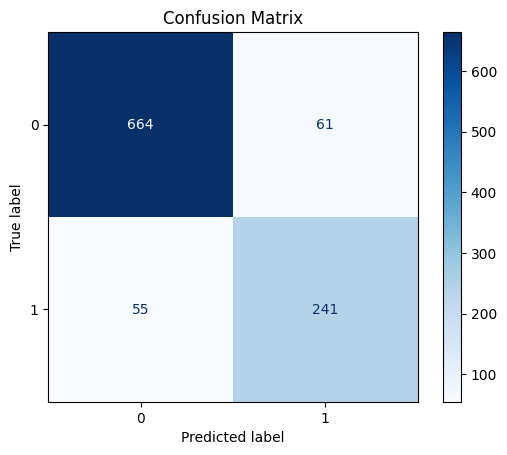

/tmp/ipykernel_8000/4182892165.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
/tmp/ipykernel_8000/4182892165.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])


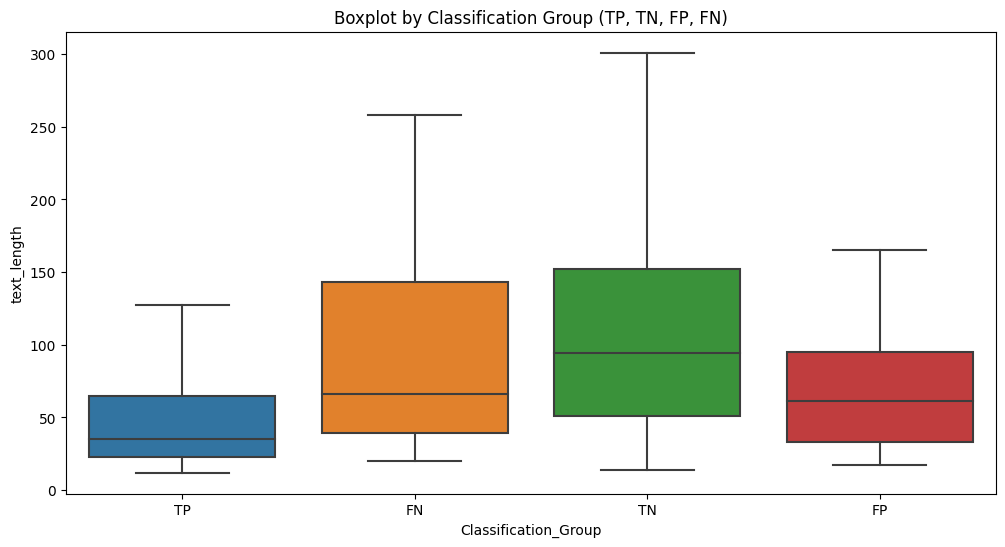

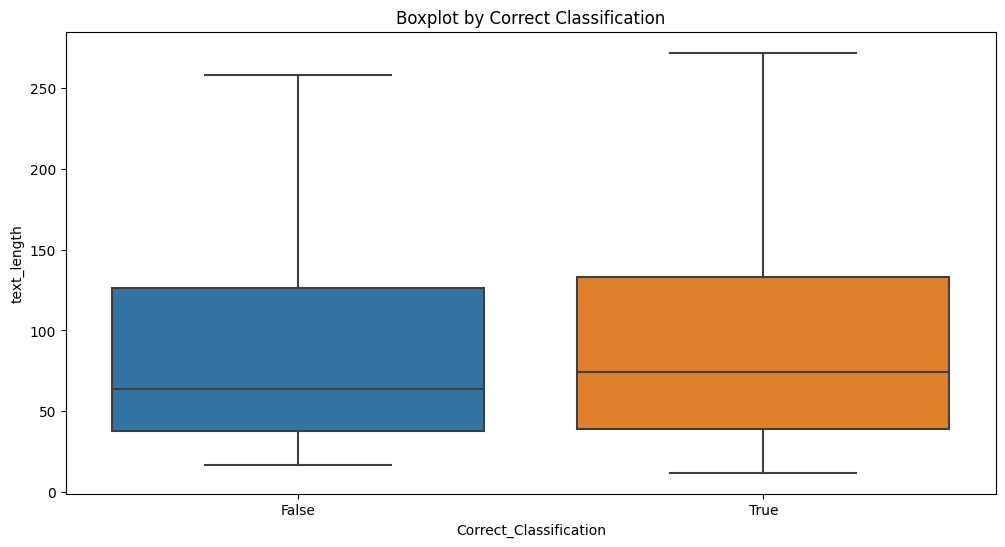

Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): 0.080
Mann-Whitney U test: p = 0.10073. No statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): -0.828
Mann-Whitney U test: p = 0.00000. Statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): 0.485
Mann-Whitney U test: p = 0.00002. Statistically significant difference.



In [60]:
# Perform the length
bias_analysis_full(analyzed_nae_df, 'text_length', 'not_an_experience', 'prediction')

<Figure size 800x600 with 0 Axes>

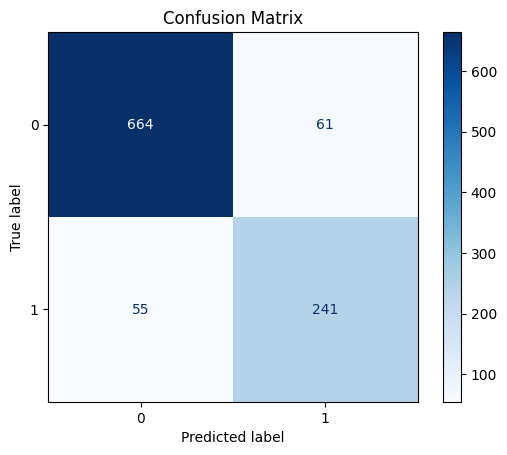

/tmp/ipykernel_8000/4182892165.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
/tmp/ipykernel_8000/4182892165.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])


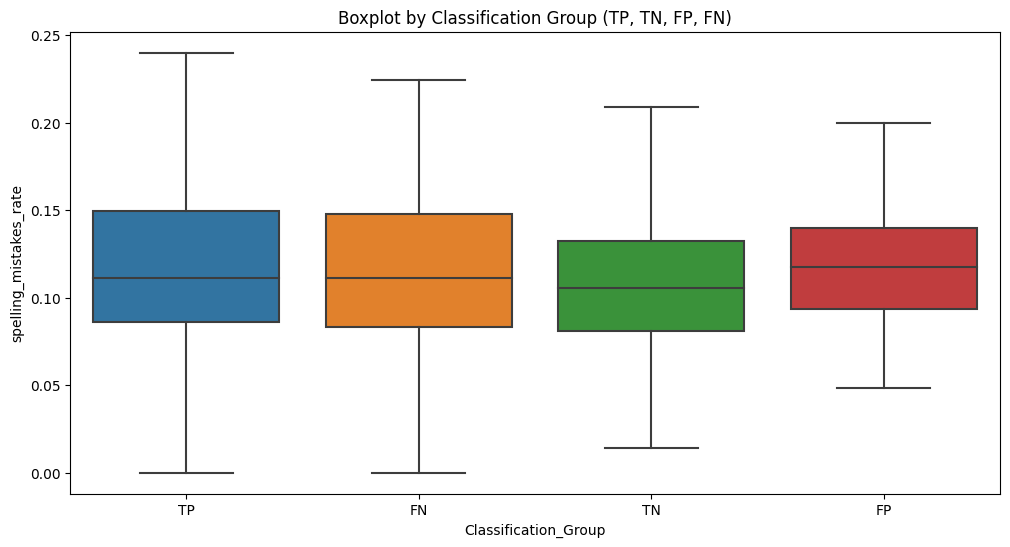

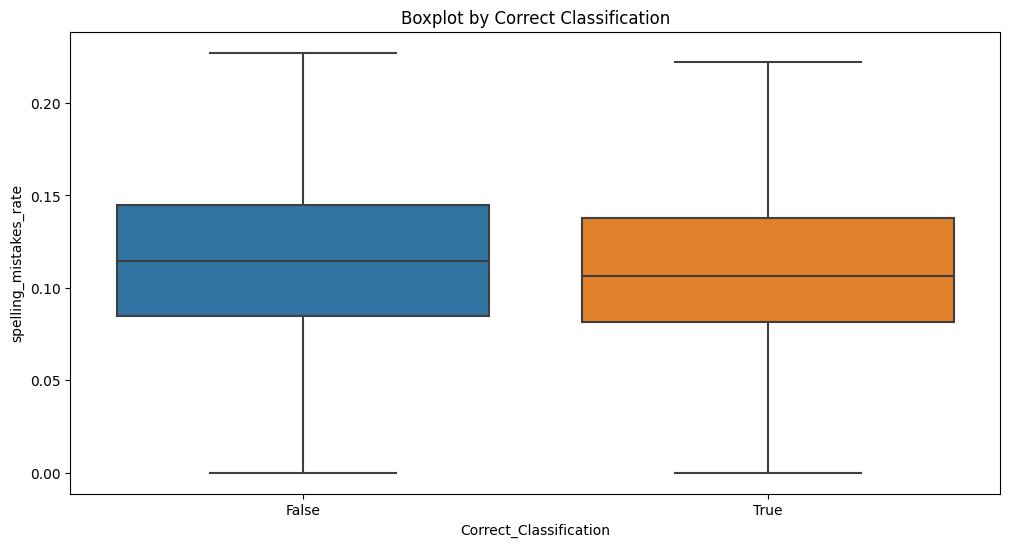

Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): -0.086
Mann-Whitney U test: p = 0.11845. No statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): 0.122
Mann-Whitney U test: p = 0.35368. No statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): -0.247
Mann-Whitney U test: p = 0.05682. No statistically significant difference.



In [61]:
# Perform the spelling mistakes
bias_analysis_full(analyzed_nae_df, 'spelling_mistakes_rate', 'not_an_experience', 'prediction')

## Complaints

In [62]:
complaints_url = # REDACT
complaints_key = # REDACTED
complaints_aml_third = # REDACT

In [63]:
test_complaints = query_endpoint('I filed a complaint and noone did anything about it', complaints_url, complaints_key, complaints_aml_third)
test_complaints

'1'

### Validation

In [64]:
def process_complaints_dataset(dataset, text_column, endpoint_url, api_key, aml_mod_deployment):
    predictions = []
    

    for text in dataset[text_column]:
        # Call the query_endpoint function
        response = query_endpoint(text, endpoint_url, api_key, aml_mod_deployment)
        
        if response is not None:

            prediction = int(response)
        else:
            # Handle cases where the query_endpoint does not return a response
            prediction = None
            

        predictions.append(prediction)
        

    # Add the predictions 
    dataset['prediction'] = predictions
    

    return dataset

In [65]:
complaints_df_withprediction =  process_complaints_dataset(complaints_val_df, 'Comment Text',  complaints_url, complaints_key, complaints_aml_third)

/tmp/ipykernel_8000/2408399372.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['prediction'] = predictions


In [66]:
analyzed_complaints_df = add_text_features_to_dataframe(complaints_df_withprediction, 'Comment Text')

/tmp/ipykernel_8000/1309993489.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['text_length'] = dataframe[text_column].apply(lambda x: len(x.split()))
/tmp/ipykernel_8000/1309993489.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['sentiment'] = dataframe[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
/tmp/ipykernel_8000/1309993489.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

The accuracy is 0.97
The F1 score is 0.86
The precision is 0.80
The recall is 0.93


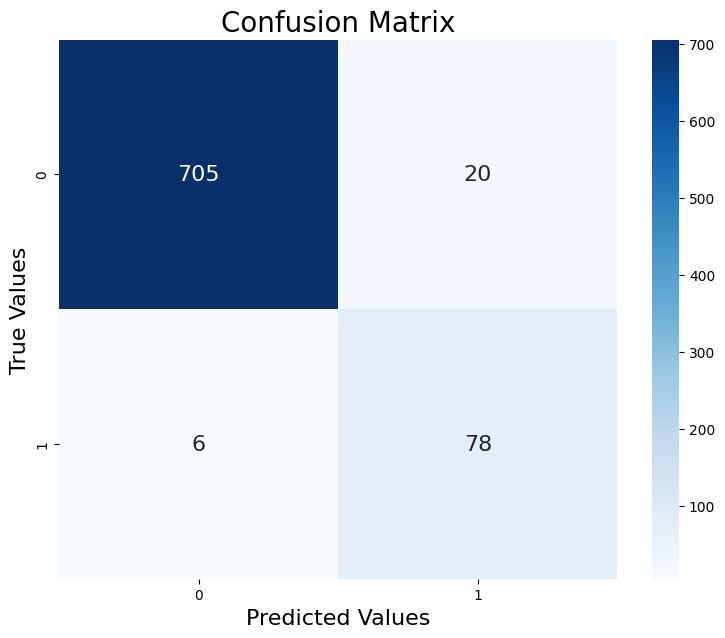

In [67]:
evaluate_predictions_given_a_dataset(complaints_df_withprediction, 'prediction', 'Is Complaint')

### Bias

<Figure size 800x600 with 0 Axes>

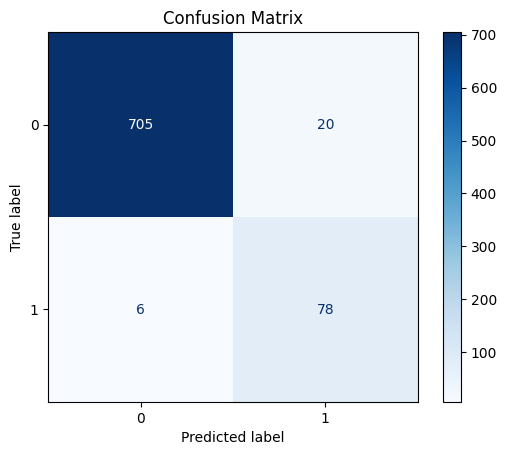

/tmp/ipykernel_8000/4182892165.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
/tmp/ipykernel_8000/4182892165.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])


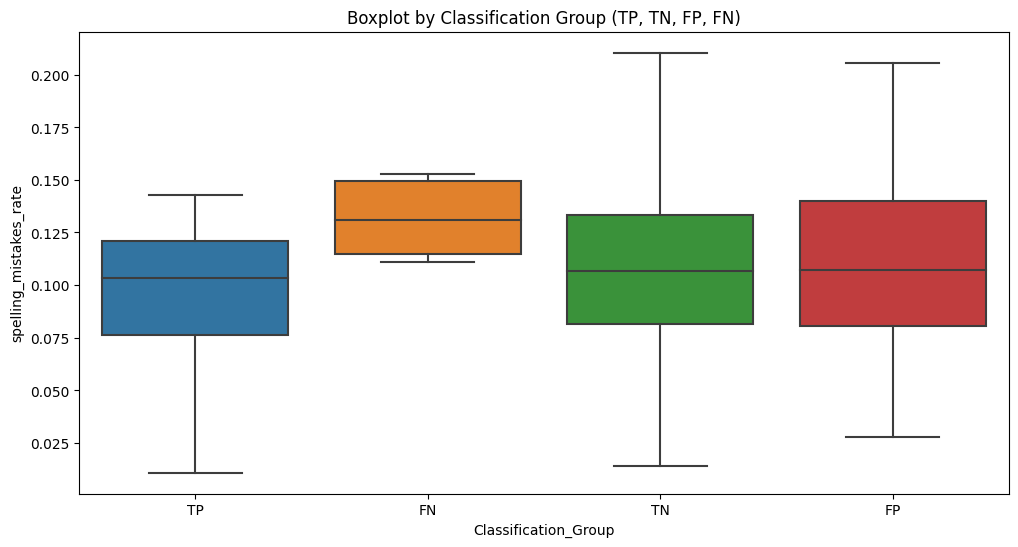

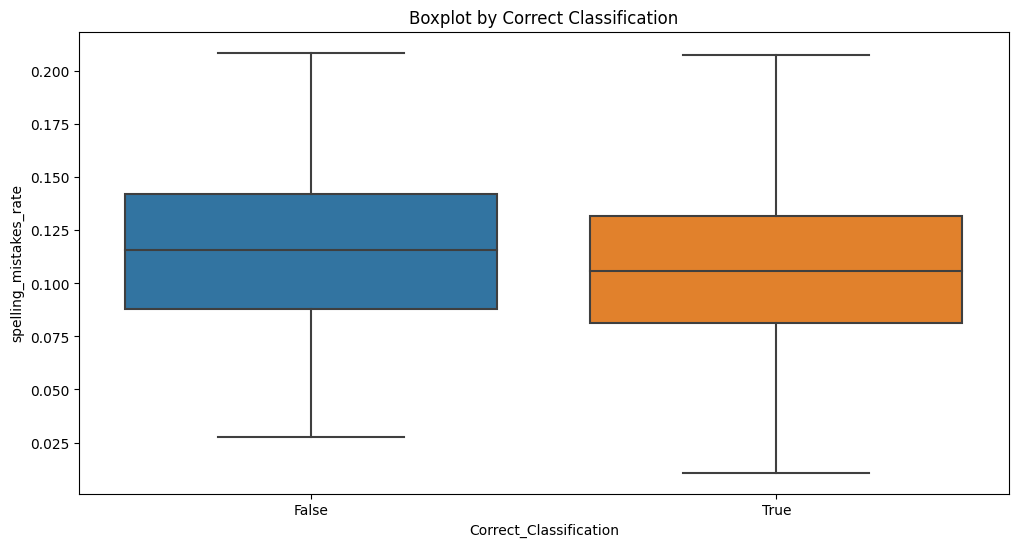

Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): -0.207
Mann-Whitney U test: p = 0.11469. No statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): -0.883
Mann-Whitney U test: p = 0.00807. Statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): -0.050
Mann-Whitney U test: p = 0.40859. No statistically significant difference.



In [69]:
# Perform the SPELLING MISTAKES
bias_analysis_full(analyzed_complaints_df, 'spelling_mistakes_rate', 'Is Complaint', 'prediction')

<Figure size 800x600 with 0 Axes>

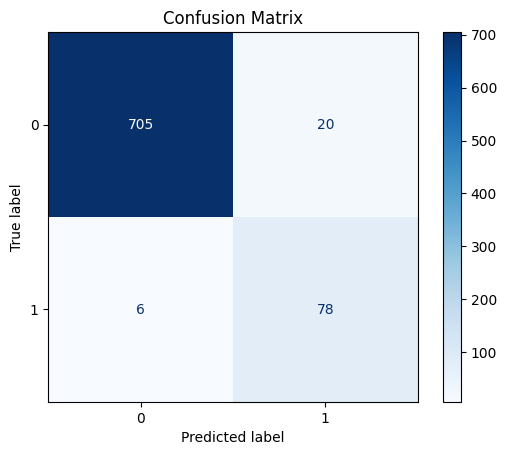

/tmp/ipykernel_8000/4182892165.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
/tmp/ipykernel_8000/4182892165.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])


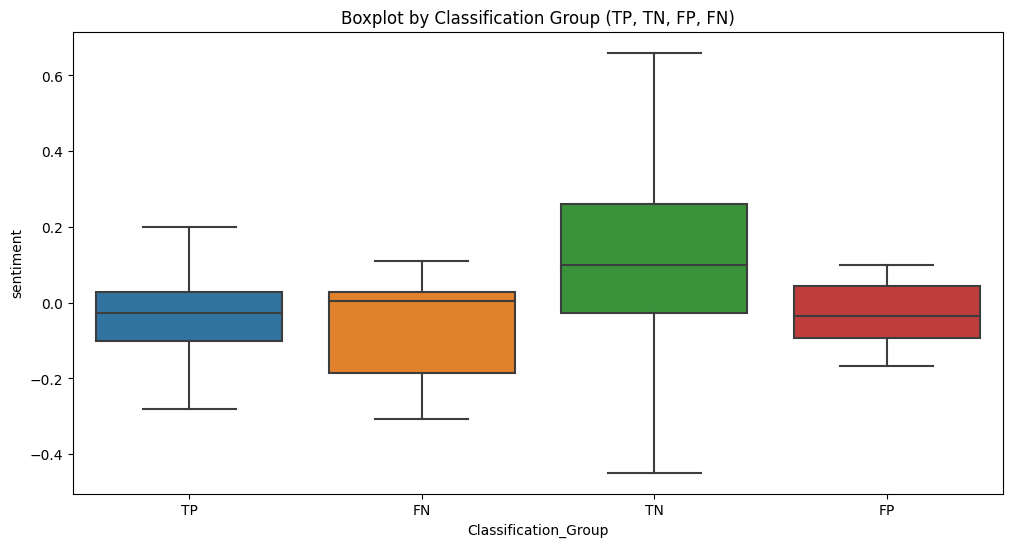

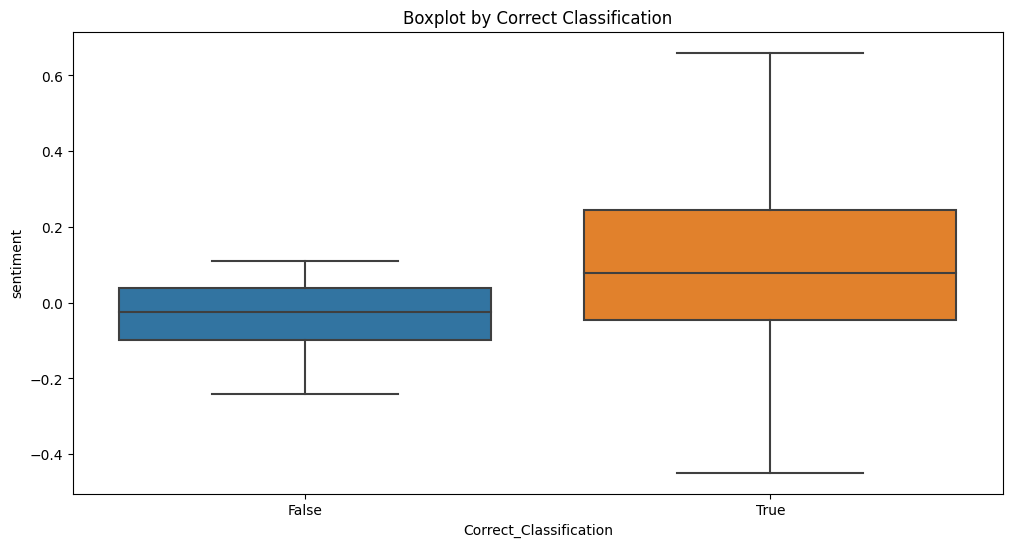

Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): 0.627
Mann-Whitney U test: p = 0.00010. Statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): 0.286
Mann-Whitney U test: p = 0.47576. No statistically significant difference.
T-test: p = 0.50179. No statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): 0.645
Mann-Whitney U test: p = 0.00016. Statistically significant difference.



In [70]:
# Perform the SENTIMENT
bias_analysis_full(analyzed_complaints_df, 'sentiment', 'Is Complaint', 'prediction')

<Figure size 800x600 with 0 Axes>

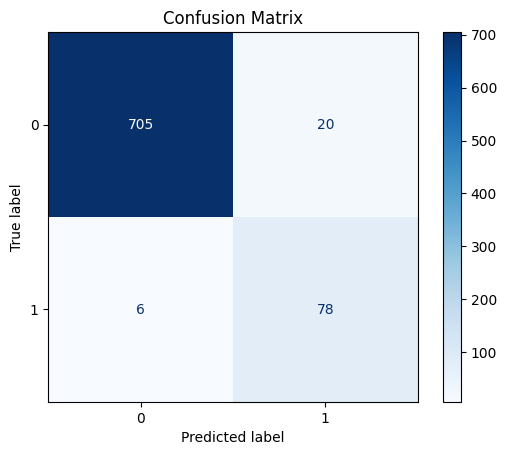

/tmp/ipykernel_8000/4182892165.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Classification_Group'] = np.select(conditions, choices, default='Unknown')
/tmp/ipykernel_8000/4182892165.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Correct_Classification'] = dataframe['Classification_Group'].isin(['TP', 'TN'])


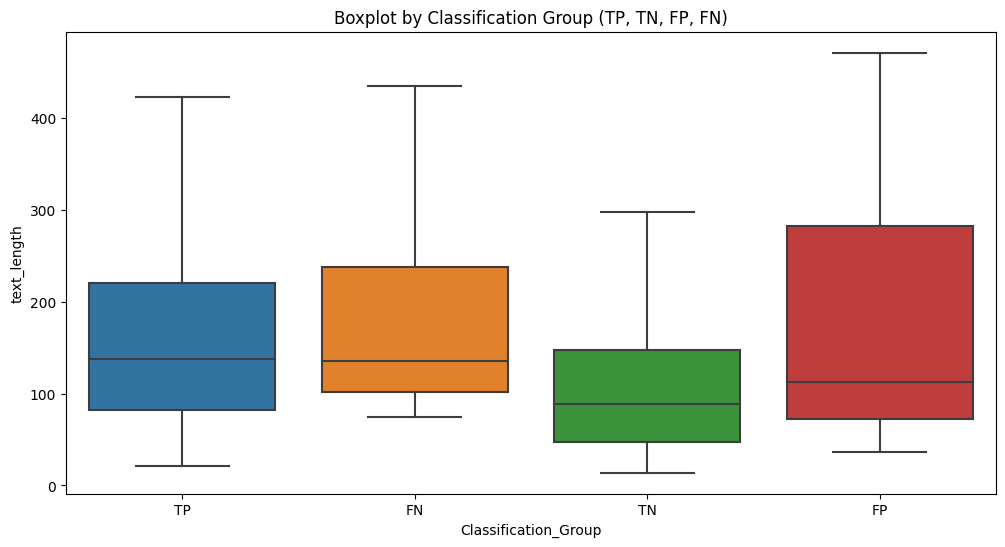

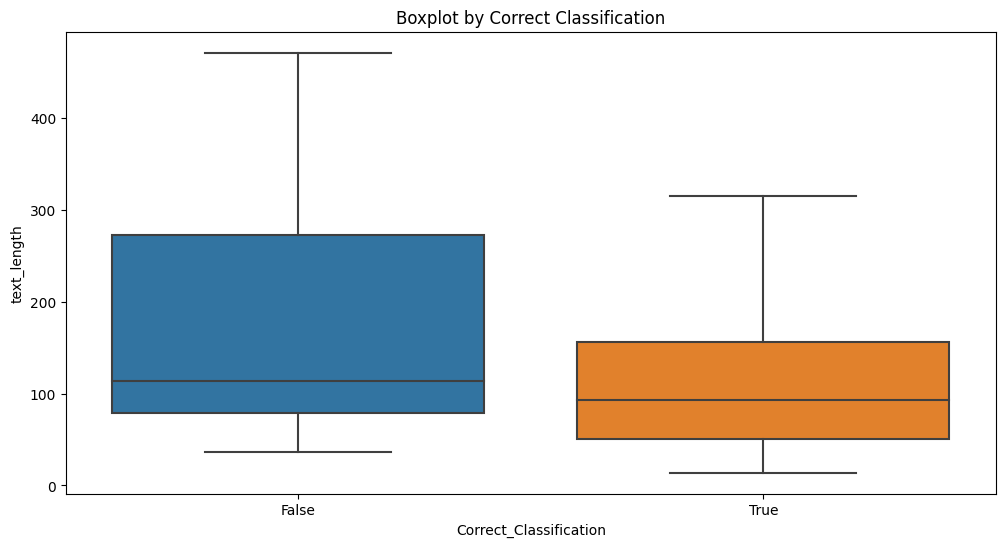

Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Normality Test for group1: Not Normal
Normality Test for group2: Normal
Normality Test for group1: Not Normal
Normality Test for group2: Not Normal
Correct vs Incorrect Classification:
Effect size (Cohen's d): -0.553
Mann-Whitney U test: p = 0.01063. Statistically significant difference.

True Positives vs False Negatives:
Effect size (Cohen's d): 0.047
Mann-Whitney U test: p = 0.42424. No statistically significant difference.


True Negatives vs False Positives:
Effect size (Cohen's d): -0.725
Mann-Whitney U test: p = 0.02215. Statistically significant difference.



In [72]:
# Perform the Length
bias_analysis_full(analyzed_complaints_df, 'text_length', 'Is Complaint', 'prediction')